#### Marketing Campaign Generator

Orchestrator: Define deliverables (Email Copy, Social Media Ads, Blog Post, Landing Page).

Workers: Write each asset.

Synthesizer: Bundle into a campaign package.

##### Patient Case Summary Generator

Orchestrator: Split case into sections (History, Symptoms, Diagnosis, Treatment).

Workers: Fill each section from patient records.

Synthesizer: Merge into case file.

In [8]:
#Installation of the required libraries
!pip install ipykernel langchain langchain-openai langgraph streamlit python-dotenv langchain-groq langchain_huggingface -q


In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
# model_name = os.getenv("MODEL_NAME")
# print(model_name)
model_name = "gemma2-9b-it"

llm=ChatGroq(model=f"{model_name}")
# # llm = ChatOpenAI(model="gpt-4o")
# result=llm.invoke("Hello")
# result

In [14]:
import os
from dotenv import load_dotenv
from openai import OpenAI

# Load environment variables from .env file
load_dotenv()

# Initialize client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [17]:
from typing_extensions import TypedDict, Annotated
import operator
from langgraph.constants import  START, END
from langgraph.types import Send
from langgraph.graph import StateGraph
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import Markdown, Image
from langchain_openai import ChatOpenAI


# os.environ["OPENAI_API_KEY"] = os.getenv("OPENAPI_KEY")

planner = ChatOpenAI(model="gpt-4o-mini")

# Graph State
class CampaignState(TypedDict):
    topic: str  # Campaign topic
    deliverables: list  # Planned deliverables (Email, Blog, Ads, etc.)
    completed_assets: Annotated[list, operator.add]  # Outputs from workers
    final_campaign: str  # Final campaign package


In [ ]:
class WorkerState(TypedDict):
    deliverable: dict  # Deliverable with name + description
    completed_assets: Annotated[list, operator.add]

# Nodes

# def orchestrator(state: CampaignState):
#     """Generate a marketing campaign plan with deliverables"""
#     campaign_plan = planner.invoke(
#         [
#             SystemMessage(content="Generate a structured marketing campaign plan."),
#             HumanMessage(content=f"Here is the campaign topic: {state['topic']}"),
#         ]
#     )
#     print("Campaign Deliverables:", campaign_plan.deliverables)
#     return {"deliverables": campaign_plan.deliverables}

def orchestrator(state: CampaignState):
    """Generate a marketing campaign plan with deliverables"""
    deliverables = [
        {"name": "Email Copy", "description": "Engaging email announcement for customers."},
        {"name": "Social Media Ads", "description": "Catchy social media ads for Twitter/LinkedIn."},
        {"name": "Blog Post", "description": "Detailed blog introducing the product."},
        {"name": "Landing Page Content", "description": "Hero Section (Big Promise / Attention Grabber), Subheading (Expand the value proposition), Key Benefits (short, scannable bullets), Social Proof / Authority Cues (trust elements, even if placeholders for now), Call to Action (clear, urgent, repeated) for a landing page."}
    ]
    print("Campaign Deliverables:", deliverables)
    return {"deliverables": deliverables}


def worker(state: WorkerState):
    """Worker generates content for one deliverable"""

    deliverable_name = state['deliverable']['name']
    deliverable_desc = state['deliverable']['description']
    topic = state['deliverable'].get('topic', state.get('topic', ''))

    # prompt = f"""
    #             You are a professional marketing copywriter. 
    #             Your task is to create the **final content** for the following deliverable.

    #             Deliverable: {deliverable_name}
    #             Description: {deliverable_desc}
    #             Campaign Topic: {topic}

    #             Instructions:
    #             - Do not ask the user questions.
    #             - Do not explain what you need. 
    #             - Directly produce the final {deliverable_name}.
    #             - Use engaging, professional, and persuasive language.
    #             - If it’s social media ads, include multiple short variations with emojis/hashtags.
    #             - If it’s a blog post, write a structured article with headings.
    #             - If it’s a landing page, include a hero headline, subheading, 3–4 bullet benefits, and a CTA button.
    #             - If it’s an email, include subject line + body with CTA.
    #             """
    prompt = f"""
                You are a senior marketing copywriter specializing in SaaS product launches. 
                Your task is to create the **final polished content** for the deliverables.  
                The campaign goal: drive early access signups. Tone: professional but approachable.

                Deliverable: {deliverable_name}
                Description: {deliverable_desc}
                Campaign Topic: {topic}

                Instructions:
                - Do not ask the user questions.
                - Do not explain what you are doing.
                - Directly produce the final {deliverable_name}.
                - Always use clear, persuasive, benefit-driven language tied to the product’s features and audience pain points.
                - Focus on conversion (clear CTA encouraging early access signup).

                Special Rules:
                - If it’s **social media ads**, generate tailored variations for multiple platforms:
                    • Twitter/X: punchy, <280 chars, emojis, hashtags.  
                    • LinkedIn: professional, benefit-focused, headline + body + CTA.  
                    • Instagram: conversational, visual, playful, include hashtags.  
                    • Facebook: friendly, relatable, slightly longer ad copy, include CTA.  
                    • TikTok (script idea): hook + problem + product intro + CTA.  
                - If it’s a **landing page**, expand beyond generic copy:
                    • Hero section: bold headline + subheading that clearly states ProWrite AI’s value.  
                    • 3–4 benefit blocks with specific product details (speed, integrations, affordability).  
                    • Social proof or credibility markers (e.g. “Built for professionals”).  
                    • Clear early access CTA button.  
                    • Optional FAQ section addressing objections (pricing, integrations, ease of use).  
                - If it’s a blog post, make it structured with sections and persuasive storytelling.  
                - If it’s an email, include subject line + preheader + body + CTA button.  

                Always ensure copy feels approachable, professional, and motivates action. 
                """


    asset = llm.invoke([SystemMessage(content=prompt)])
    return {"completed_assets": [f"## {deliverable_name}\n\n{asset.content}"]}

def synthesizer(state: CampaignState):
    """Merge campaign assets into final package"""
    completed_assets = state["completed_assets"]
    final_doc = "\n\n---\n\n".join(completed_assets)
    return {"final_campaign": final_doc}


In [32]:
# Conditional Edge (parallel workers)
def assign_workers(state: CampaignState):
    """Assign a worker to each deliverable in the plan"""
    return [Send("worker", {"deliverable": d}) for d in state["deliverables"]]

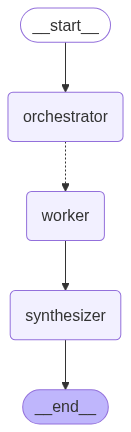

Campaign Deliverables: [{'name': 'Email Copy', 'description': 'Engaging email announcement for customers.'}, {'name': 'Social Media Ads', 'description': 'Catchy social media ads for Twitter/LinkedIn.'}, {'name': 'Blog Post', 'description': 'Detailed blog introducing the product.'}, {'name': 'Landing Page Content', 'description': 'Hero section, subheading, and CTA for a landing page.'}]


## Email Copy

## Email Copy: 

**Subject: Introducing ProWrite AI: Reimagine Your Writing Workflow**

**Preheader:  Say goodbye to writer's block and hello to effortless content creation.**

Your writing process is about to get a whole lot easier. 

We're thrilled to announce ProWrite AI, a revolutionary new tool designed to supercharge your productivity and elevate your content. 

Imagine crafting compelling blog posts in minutes, generating polished emails with ease, and overcoming writer's block in an instant. ProWrite AI makes it all possible with its powerful AI-driven features:

* **Effortless Content Generation:**  ProWrite AI generates high-quality content on any topic, saving you valuable time and energy.

* **Seamless Integrations:**  Connect ProWrite AI with your favorite tools like Slack, Google Docs, and more for a streamlined workflow.

* **Unmatched Accuracy and Clarity:**  ProWrite AI ensures your content is grammatically flawless and easy to understand.

**Ready to experience the future of writing?**

[Sign up for early access now](link to landing page) and be among the first to unlock the power of ProWrite AI.




---

## Social Media Ads

## ProWrite AI Social Media Ads:

**Twitter/X:**

Tired of writer's block? 😩  ProWrite AI generates high-quality content in seconds! 🚀  

Join the waitlist for early access: [link to landing page] #AIwriting #ContentMarketing #Productivity

**LinkedIn:**

**Headline:** Supercharge Your Content Creation with ProWrite AI

**Body:**  Struggling to keep up with content demands? ProWrite AI leverages cutting-edge AI technology to generate compelling website copy, blog posts, and marketing materials – saving you time and boosting your output.  

**CTA:**  Request Early Access Now: [link to landing page]

**Instagram:**

[Image: Mockup of ProWrite AI generating a creative text output]

Caption:  Say goodbye to staring at a blank page 👋  ProWrite AI is here to help you write more, faster, and smarter! ✨  

Get on the waitlist for exclusive early access: [link to landing page] #AIwriting #ContentCreation #NoMoreWritersBlock

**Facebook:**

We get it.  Content creation can be a struggle. 😩  But what if you had a secret weapon to help you write better, faster? 🤔  

Introducing ProWrite AI – your new AI-powered writing assistant that generates high-quality content in seconds!  

Join the early access list today and see the difference ProWrite AI can make: [link to landing page]

**TikTok:**

**(Hook):** Ever feel stuck when trying to write something? 

**(Problem):**  Writer's block is real, and it can cost you time and money!

**(Product Intro):** But ProWrite AI is here to save the day! It generates amazing content in seconds, so you can focus on what matters most.

**(CTA):** Want to try it? Sign up for early access now! [link to landing page] #AIwriting #ProWriteAI #ContentCreationMadeEasy 



Let me know if you need help with other deliverables! 


---

## Blog Post

##  Stop Staring at a Blank Page:  Introducing ProWrite AI, Your New Content Powerhouse

Let's be honest, writer's block is the bane of every content creator's existence.  That dreaded blank page can feel like an insurmountable obstacle, stealing precious time and hindering your productivity. But what if you had a secret weapon, an AI-powered assistant that could transform your brainstorming sessions into a seamless flow of creative brilliance? 

Introducing ProWrite AI, the revolutionary new tool designed to supercharge your content creation process. 

**More Than Just an Idea Generator**

ProWrite AI isn't just another AI writing tool that spits out generic text.  It's a sophisticated platform built to understand your unique needs and help you craft compelling, original content in minutes.  Here's how:

* **Lightning-Fast Generation:** Struggling to come up with compelling headlines?  Need to brainstorm blog post ideas quickly? ProWrite AI can generate multiple high-quality options in seconds, freeing you to focus on refining and polishing your work.
* **Seamlessly Integrate with Your Workflow:**  ProWrite AI works seamlessly with your existing tools. Whether you're a WordPress enthusiast, a Google Docs devotee, or a Notion power user, ProWrite AI integrates effortlessly to keep your content creation flow uninterrupted. 
* **Unleash Your Creative Potential:** ProWrite AI isn't about replacing your voice; it's about amplifying it.  Use it to overcome writer's block, explore new angles, and discover innovative ways to express your ideas. 

**Content Creation Reimagined**

Imagine a world where writer's block is a distant memory, where you can effortlessly produce high-quality content on demand, and where your creativity knows no bounds. 

With ProWrite AI, that world is now a reality.

**Join the ProWrite AI Revolution**

Ready to experience the future of content creation?  Sign up for our early access program today and unlock the power of ProWrite AI. 




---

## Landing Page Content

## ProWrite AI Landing Page Content

**Hero Section**

**Headline:**  Say Goodbye to Writer's Block, Hello to ProWrite AI.

**Subheading:**  Effortlessly craft high-quality content at lightning speed.

**Benefit Blocks:**

* **Boost Your Productivity:**  ProWrite AI generates compelling content in seconds, saving you valuable time and effort.  Focus on strategy, not staring at a blank page.

* **Seamless Integrations:**  ProWrite AI integrates with your favorite tools, streamlining your workflow and keeping you in the creative flow.  

* **Unbeatable Value:**  ProWrite AI's powerful AI technology is accessible to everyone, no matter your budget.  Unlock professional-grade writing at a fraction of the cost.

**Social Proof:**

Built for professionals by professionals.

**Early Access CTA Button:**  Get Early Access Now!


**Optional FAQ Section:**

**Q: What types of content can ProWrite AI generate?**

A: ProWrite AI can help you create a wide range of content, including blog posts, articles, website copy, social media captions, email marketing campaigns, and more.

**Q: Do I need any technical skills to use ProWrite AI?**

A: Absolutely not! ProWrite AI is designed to be user-friendly and accessible to everyone.

**Q: What are the pricing options for ProWrite AI?**

A: We offer flexible pricing plans to fit your needs.  Sign up for early access to learn more about our special launch offers.





In [33]:
# Build Workflow
campaign_builder = StateGraph(CampaignState)

# Add nodes
campaign_builder.add_node("orchestrator", orchestrator)
campaign_builder.add_node("worker", worker)
campaign_builder.add_node("synthesizer", synthesizer)

# Add edges
campaign_builder.add_edge(START, "orchestrator")
campaign_builder.add_conditional_edges("orchestrator", assign_workers, ["worker"])
campaign_builder.add_edge("worker", "synthesizer")
campaign_builder.add_edge("synthesizer", END)

# Compile workflow
campaign_workflow = campaign_builder.compile()

# Show workflow graph
display(Image(campaign_workflow.get_graph().draw_mermaid_png()))


# Run Workflow
state = campaign_workflow.invoke({
    "topic": """

                The product is: ProWrite AI — an AI-powered writing assistant for professionals 
                (marketers, consultants, writers). It helps create high-quality content 3x faster, 
                integrates with Google Docs & Notion, and is more affordable than competitors.

Goal: Early access signups. 
Tone: Professional but approachable. 
"""
})


Markdown(state["final_campaign"])